In [19]:
%matplotlib inline
import os
import xray
import numpy as np

In [20]:
def point_to_center_dict(pLat, pLon, iLat=2.5, iLon=2.5):
    
    # iLat and iLon are the intervals between nodes
    
    cLat = int((pLat + iLat / 2) / iLat) * iLat  # c means CENTRER
    cLon = int((pLon + iLon / 2) / iLon) * iLon

    return {'cLat':cLat, 'cLon':cLon}



def get_interested_month_slice(interested_month, start_year, end_year):

    start = str(start_year) + '-' + str(interested_month)

    end = str(end_year) + '-' + str(interested_month)
    
    return slice(start,end,12)



def extract_subset_dict_for_month_and_point(i_month=7,
                                            i_year_start=1960,
                                            i_year_end=2009,
                                            i_level=850,
                                            i_point_lat=51.8167,
                                            i_point_lon=68.3667,
                                            i_nodes_expanded=1, 
                                            i_Lat=2.5, 
                                            i_Lon=2.5):
    
    # construct a dict containing all selection info
    
    domain_dict = point_to_center_dict( i_point_lat , i_point_lon , i_Lat, i_Lon)
    
    cLat = domain_dict['cLat']
    cLon = domain_dict['cLon']
    
    lat=slice(cLat + i_nodes_expanded * i_Lat, cLat - i_nodes_expanded * i_Lat)
    lon=slice(cLon - i_nodes_expanded * i_Lon, cLon + i_nodes_expanded * i_Lon)
        
    parameter_dict = {'lat':lat, 'lon':lon}
    
    
    time_dict = dict(time=get_interested_month_slice(i_month,i_year_start, i_year_end))    
    parameter_dict.update(time_dict)
    
    
    level_dict = {'level':i_level}
    parameter_dict.update(level_dict)
    
    return parameter_dict

In [21]:
from sklearn import preprocessing
from sklearn.decomposition import pca
import pandas as pd

In [22]:
def get_PCs_info(dsub, i_year_start, i_year_end, threshold=0.9):
    dim_lat = dsub['lat'].values
    dim_lon = dsub['lon'].values
    var_values = dsub.values

    var_values = np.reshape(var_values, (var_values.shape[0], len(dim_lat) * len(dim_lon)), order='F')
    
    var_values_scaled = preprocessing.scale(var_values)
    
    skpca = pca.PCA()
    skpca.fit(var_values_scaled)
    PCs = skpca.transform(var_values_scaled)

    i = 0
    pc_info_list = []
    while True:

        explained_variance = skpca.explained_variance_ratio_[i]
        pc_value = PCs[:,i]

        row = {'PC_VALUE':pc_value,'YEAR': np.arange(i_year_start,i_year_end+1)}
        df_pc_year = pd.DataFrame(row)
        df_pc_year['EV'] = explained_variance
        pc_info_list.append(df_pc_year)    
        if skpca.explained_variance_ratio_.cumsum()[i] >= threshold:
            break
        i = i+1
    return pd.concat(pc_info_list)

In [23]:
def get_PC_main(dset, i_point_lat, i_point_lon, i_year_start, i_year_end, i_month, i_var, i_level):
    
    # i for interested
    i_point_lat = i_point_lat
    i_point_lon = i_point_lon

    i_year_start = i_year_start
    i_year_end = i_year_end
    i_month = i_month

    i_var = i_var

    i_level = i_level
    
    
    
    # select a sub area for both time and spatial dimensions
    subset_parameters_dict = extract_subset_dict_for_month_and_point(   i_month = i_month,
                                                                    i_year_start = i_year_start,
                                                                    i_year_end = i_year_end,
                                                                    i_level = i_level,
                                                                    i_point_lat = i_point_lat,
                                                                    i_point_lon = i_point_lon)
    
    dsub = dset[i_var].loc[subset_parameters_dict]
    
    
    # extract the first several PCs 
    
    pc_table = get_PCs_info(dsub,i_year_start, i_year_end, threshold=0.9)
    
    pc_table['MONTH'] = i_month
    pc_table['VAR_NAME'] = i_var
    pc_table['LEVEL'] = i_level
    
    return pc_table

In [24]:
def loop_for_var(dset, station_pd, i_year_start, i_year_end, i_var, i_level_list=[925., 850., 500.]):
    
    result_table = []
    
    for row in range(len(station_pd)):
        i_point_lat = station_pd.iloc[row].ix['LATITUDE']
        i_point_lon = station_pd.iloc[row].ix['LONGITUDE']   
    
        i_var = i_var

        levels = i_level_list
        months = range(1,13)

        table_list_month = []

        for month in months:    
            for level in levels:
                table_list_month.append(get_PC_main(dset, i_point_lat, i_point_lon, i_year_start, i_year_end, month, i_var, level))
        
        table_list_station = pd.concat(table_list_month, ignore_index=True)
        table_list_station['STATION_NAME'] = station_pd.iloc[row].ix['STATION_NAME']
        result_table.append(table_list_station)
    
    #print result_table
    
    return pd.concat(result_table, ignore_index=True)

In [25]:
def final_extract(station_pd, var_list, i_year_start, i_year_end, level_list=[925., 850., 500.]):
    
    nc_path = '/home/ek777/Documents/Downscaling/ncep_monthly_mean/surface'
    
    result_list = []
    
    for var in var_list:
        nc_name = str(var) + '.mon.mean.nc'
        path = os.path.join(nc_path, nc_name)
        dset = xray.open_dataset(path)
        
        result_list.append(loop_for_var(dset, station_pd, i_year_start, i_year_end, var, level_list))
        
        #print('%s has completed.' % str(var))
    
    final_result_PC_info = pd.concat(result_list, ignore_index=True)    
    
    return final_result_PC_info

In [26]:
station_test = pd.DataFrame({'STATION_NAME':['TEST', 'AKTOBE','URALSK','UIL'],'LATITUDE':[51.8167,50.2831,51.2500,49.0667],'LONGITUDE':[68.3667,57.1500,51.4000,54.6831]})

In [27]:
station_test

,LATITUDE,LONGITUDE,STATION_NAME
0,51.8167,68.3667,TEST
1,50.2831,57.1500,AKTOBE
2,51.2500,51.4000,URALSK
3,49.0667,54.6831,UIL


In [31]:
year_start = 1980
year_end = 2000

In [29]:
var_list = ['air', 'hgt']
predictors_list = ['air', 'hgt', 'uwnd', 'vwnd']
level_list = [925., 850., 500.]

In [32]:
final_result_PC_info = final_extract(station_test, var_list, year_start, year_end)

In [33]:
final_result_PC_info.set_index('LEVEL').ix[925]

,PC_VALUE,YEAR,EV,MONTH,VAR_NAME,STATION_NAME
LEVEL,,,,,,
925,-5.680273,1980,0.913774,1,air,TEST
925,2.909877,1981,0.913774,1,air,TEST
925,-1.103923,1982,0.913774,1,air,TEST
925,3.504433,1983,0.913774,1,air,TEST
925,4.560509,1984,0.913774,1,air,TEST
925,1.029766,1985,0.913774,1,air,TEST
925,2.305781,1986,0.913774,1,air,TEST
925,-2.559705,1987,0.913774,1,air,TEST
925,-0.628146,1988,0.913774,1,air,TEST


## ANALYSIS

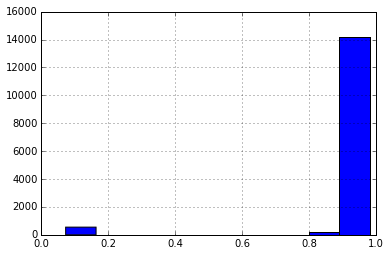

In [14]:
final_result_PC_info.EV.hist()

In [15]:
final_result_PC_info.to_csv('pc_out.csv',index=False)

In [16]:
fd = pd.read_csv('pc_out.csv')

In [17]:
fd

,PC_VALUE,YEAR,EV,MONTH,VAR_NAME,LEVEL,STATION_NAME
0,0.415180,1960,0.953897,1,air,925,TEST
1,1.961150,1961,0.953897,1,air,925,TEST
2,1.406489,1962,0.953897,1,air,925,TEST
3,2.232663,1963,0.953897,1,air,925,TEST
4,-1.098547,1964,0.953897,1,air,925,TEST
5,1.474089,1965,0.953897,1,air,925,TEST
6,0.178628,1966,0.953897,1,air,925,TEST
7,0.473063,1967,0.953897,1,air,925,TEST
8,0.830857,1968,0.953897,1,air,925,TEST
9,-9.496139,1969,0.953897,1,air,925,TEST
